# Combining sources
This document combines all relevant sources into two datasets:
- daily downloads across all shows
- episodic totals, tagged by show

Sources:
- [x] Legacy LibSyn
- [x] Legacy HIO Sounder.fm
- [x] Simplecast HIO
- [x] Simplecast TBP
- [ ] ~~Legacy SoundCloud~~
- [ ] ~~Spotify~~ only 1k (+1k from old) streams for HIO
- [ ] ~~YouTube (maybe)~~ 8.7k views over TBP lifetime
- [ ] TBP Patreon

In [8]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
plt.style.use('ggplot')
import datetime as dt
import plotly.express as px

## Simplecast (Both HIO and TBP)

The timeline ranges from 2019-02-XX - Current

for details on data files, review the "Exploring_Simplecast.ipynb" file

So far, we have not created proper data for the daily stats. They need to be pulled from episodic data and tallied, which requires quite a bit of work. 

In [16]:
hio_simplecast_episodic = pd.read_feather("hio_episodic_downloads.feather")
hio_simplecast_episodic = hio_simplecast_episodic[['title', 'total_downloads', 'published_at']].copy()
hio_simplecast_episodic.rename(columns={"total_downloads":"downloads", 'published_at':'date'}, inplace=True)
tbp_simplecast_episodic = pd.read_feather("tbp_episodic_downloads.feather")
tbp_simplecast_episodic = tbp_simplecast_episodic[['title', 'total_downloads', 'published_at']].copy()
tbp_simplecast_episodic.rename(columns={"total_downloads":"downloads", 'published_at':'date'}, inplace=True)
simplecast_totals = pd.read_feather("total_podcast_downloads.feather")
tbp_simplecast_daily = pd.read_csv("raw_data/simplecast/podcast_downloads_The-Bitcoin-Podcast.csv")
tbp_simplecast_daily.rename(columns={"downloads_total":"downloads", "interval":"date"}, inplace=True)

In [12]:
tbp_simplecast_daily

,downloads_percent,downloads,date
0,0.00000,1,2019-02-12
1,0.00115,2377,2019-02-13
2,0.00169,3485,2019-02-14
3,0.00190,3917,2019-02-15
4,0.00339,6989,2019-02-16
...,...,...,...
1442,0.00087,1788,2023-01-24
1443,0.00043,884,2023-01-25
1444,0.00025,525,2023-01-26
1445,0.00035,732,2023-01-27


In [36]:
hio_simplecast_episodic.head()

,title,downloads,date
0,Flash Hash: 01/09/2023,24,2023-01-09T03:34:06Z
1,Flash Hash 01/02/2023,2,2023-01-02T22:11:26Z
2,Hashing It Out Personals: Dee Ferguson,3,2022-12-19T03:47:17Z
3,Application infrastructure Pt. 2,79,2022-12-13T19:19:37Z
4,Flash Hash: 12/05/2022,4,2022-12-06T03:30:00Z


In [37]:
hio_simplecast_episodic.downloads.sum()

269

In [34]:
tbp_simplecast_episodic.head()

,title,downloads,date
0,Hashing It Out-Flash Hash 01/02/2023,937,2023-01-24T17:00:00Z
1,Hashing It Out Personals: Dee Ferguson,1259,2023-01-17T17:00:00Z
2,Hashing It Out-Application Infrastructure Pt. 2,1333,2023-01-10T17:00:00Z
3,Hashing It Out-Flash Hash: 12/05/2022,1378,2023-01-03T17:00:00Z
4,Hashing It Out-Application Infrastructure Pt. 1,1505,2022-12-27T17:00:00Z


In [39]:
tbp_simplecast_episodic.downloads.sum()

2059381

## Legacy Libsyn

The timeline ranges from 2015-06-15 - 2019-02-17

for details on data files, review the "Exploring-downloads.ipynb" file

In [17]:
tbp_libsyn_daily = pd.read_csv("raw_data/daily-totals_2019-02-17.csv")
tbp_libsyn_daily.rename(columns = {"total_downloads":"downloads"}, inplace=True)
tbp_libsyn_episodic = pd.read_csv("dash_app/episode_data.csv")
tbp_libsyn_episodic.rename(columns={"release_date":"date"}, inplace=True)
tbp_libsyn_episodic = tbp_libsyn_episodic[['title', 'date', 'downloads']].copy()

In [10]:
tbp_libsyn_daily.head()

,date,downloads
0,2015-06-01,127.0
1,2015-06-02,32.0
2,2015-06-03,15.0
3,2015-06-04,8.0
4,2015-06-05,36.0


In [40]:
tbp_libsyn_episodic.tail()

,title,date,downloads
337,Episode #21: On-Ramping with Dee,2018-03-12,3945.0
338,"Buy or Sell, What the Hell #16: Wishful Thinking",2018-03-14,3824.0
339,"Buy or Sell, What the Hell #17: Confidence is Key",2018-03-16,2446.0
340,TBP Presents: Social Implementations of Blockc...,2018-03-16,2933.0
341,Creating a Humanist Blockchain Future #34,2018-03-17,1138.0


## Legacy Sounder.fm

In [22]:
hio_sounder_episodic = pd.read_csv("raw_data/hio_sounder/episodes_summary.csv")
hio_sounder_episodic = hio_sounder_episodic[['episode_title','episode_release_date','streams_all_time']]
hio_sounder_episodic.rename(columns={"episode_title":"title", "episode_release_date":"date", "streams_all_time":"downloads"}, inplace=True)

In [23]:
hio_sounder_episodic

,title,date,downloads
0,Hashing It Out #1: Nick Johnson,2018-04-03 19:58:51,132
1,Hashing It Out #66 - Trueblocks - Thomas Jay Rush,2019-11-08 03:35:19,67
2,Hashing It Out #45 - Cosmos Network - Zaki Manian,2019-05-10 17:41:37,70
3,Hashing It Out #51 - Blockstream - Andrew Poel...,2019-07-04 19:48:18,48
4,Hashing It Out #56 - Mattereum - Vinay Gupta,2019-08-16 12:29:42,41
...,...,...,...
127,Flash Hash: 12/05/2022,2022-12-06 03:30:00,150
128,Application infrastructure Pt. 2,2022-12-13 19:19:37,136
129,Hashing It Out Personals: Dee Ferguson,2022-12-19 03:47:17,153
130,Flash Hash 01/02/2023,2023-01-02 22:11:26,111


## Combining sources

## Daily Downloads

In [17]:
df_daily = pd.concat([tbp_libsyn_daily, tbp_simplecast_daily], ignore_index=True)
df_daily.sort_values(by='date')

,date,downloads,downloads_percent
0,2015-06-01,127.0,NaN
1,2015-06-02,32.0,NaN
2,2015-06-03,15.0,NaN
3,2015-06-04,8.0,NaN
4,2015-06-05,36.0,NaN
...,...,...,...
2800,2023-01-24,1788.0,0.00087
2801,2023-01-25,884.0,0.00043
2802,2023-01-26,525.0,0.00025
2803,2023-01-27,732.0,0.00035


<AxesSubplot: >

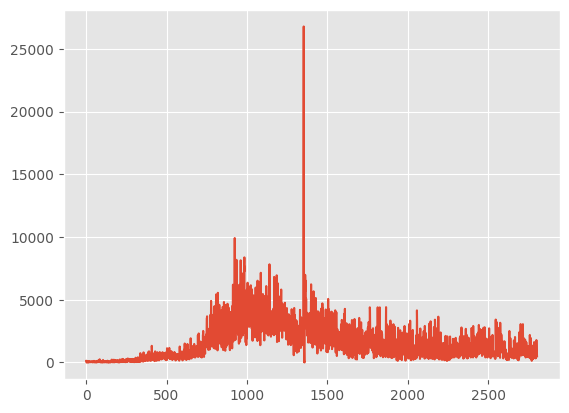

In [19]:
df_daily.downloads.plot()

## Episodic Downloads

In [18]:
df_episodic = tbp_simplecast_episodic.merge(tbp_libsyn_episodic, how='left', on='title').sort_values(by='date_x')
df_episodic.downloads_y.fillna(0, inplace=True)
df_episodic.downloads_x.fillna(0, inplace=True)
df_episodic['downloads'] = df_episodic['downloads_x'] + df_episodic['downloads_y']
df_episodic['date'] = pd.to_datetime(df_episodic['date_x'], infer_datetime_format=True)

In [102]:
df_episodic

,title,downloads_x,date_x,date_y,downloads_y,downloads,date
1008,Episode #1 - Introduction,376,2015-06-01T00:34:44Z,2015-06-01,3192.0,3568.0,2015-06-01 00:34:44+00:00
1007,TBP02 - Holding Up the Sky,301,2015-06-08T08:00:00Z,2015-06-07,2559.0,2860.0,2015-06-08 08:00:00+00:00
1006,TBP03 - Bridging the Gender Gap,283,2015-06-15T07:00:00Z,2015-06-15,2402.0,2685.0,2015-06-15 07:00:00+00:00
1005,TBP04 - Change Jar 2.0,280,2015-06-22T06:30:00Z,2015-06-20,2519.0,2799.0,2015-06-22 06:30:00+00:00
1004,TBP05 - The World's Strongest,263,2015-06-29T06:30:00Z,2015-06-28,2396.0,2659.0,2015-06-29 06:30:00+00:00
...,...,...,...,...,...,...,...
4,Hashing It Out-Application Infrastructure Pt. 1,1505,2022-12-27T17:00:00Z,NaN,0.0,1505.0,2022-12-27 17:00:00+00:00
3,Hashing It Out-Flash Hash: 12/05/2022,1378,2023-01-03T17:00:00Z,NaN,0.0,1378.0,2023-01-03 17:00:00+00:00
2,Hashing It Out-Application Infrastructure Pt. 2,1333,2023-01-10T17:00:00Z,NaN,0.0,1333.0,2023-01-10 17:00:00+00:00
1,Hashing It Out Personals: Dee Ferguson,1259,2023-01-17T17:00:00Z,NaN,0.0,1259.0,2023-01-17 17:00:00+00:00


In [19]:
df_episodic.downloads.sum()

4230676.0

In [20]:
tbp_simplecast_episodic.downloads.sum()

2059381

In [21]:
tbp_libsyn_episodic.downloads.sum()

2326700.0

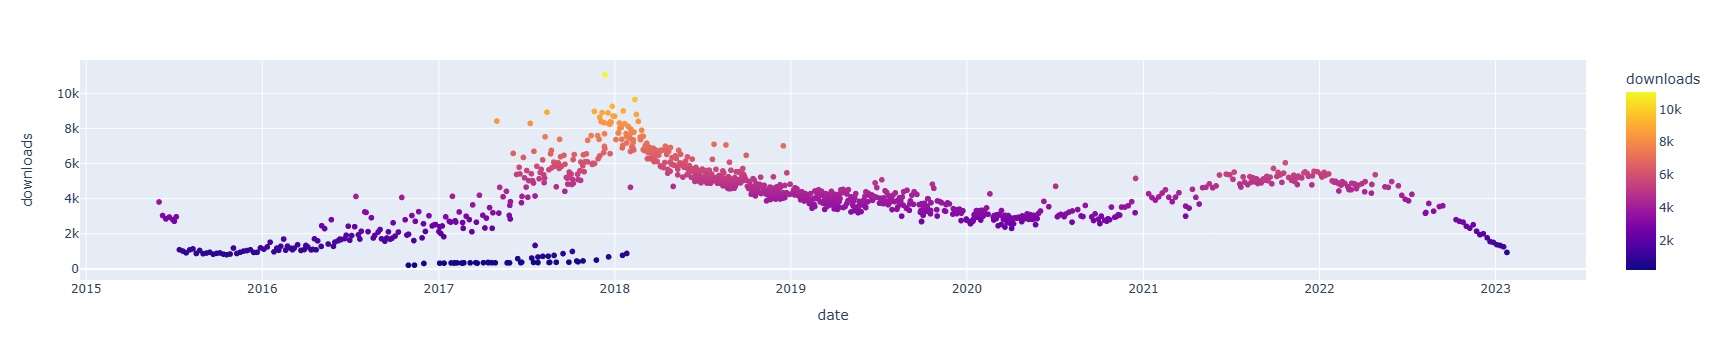

In [22]:
fig = px.scatter(df_episodic, x="date", y="downloads", color='downloads', hover_name='title')
fig.show()

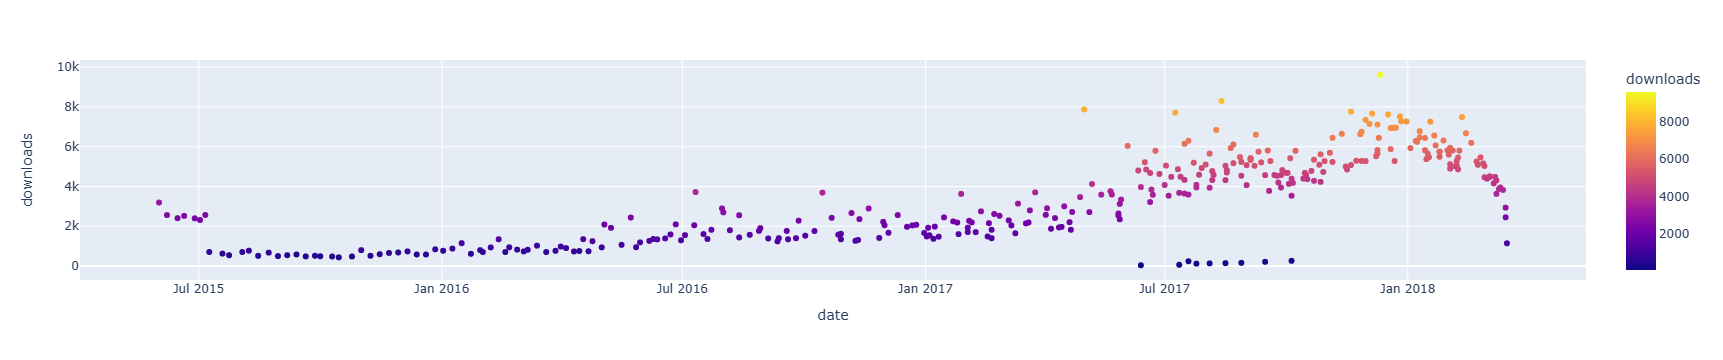

In [15]:
fig = px.scatter(tbp_libsyn_episodic, x="date", y="downloads", color='downloads', hover_name='title')
fig.show()